# Correspondence AutoEncoder

## 1. Import Libraries

In [1]:
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
from collections import Counter
import kaldi_io
import argparse
import sys
from numpy.random import default_rng
from matplotlib import pyplot as plt

#scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics import PrecisionRecallDisplay,precision_recall_curve
from sklearn.metrics.pairwise import pairwise_kernels

#Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

#Import User defined classes
from train_test_helpers import accuracy,train_loop
from datasets import CNN_dataset, SiameseTriplets


#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset



################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
print(tf.test.is_built_with_cuda()) #If TF is using GPU
print(tf.config.list_physical_devices('GPU')) #List the GPU Device

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Data Loading and Common Functions

In [3]:
snr = np.Inf

In [4]:
#Load Data using torch dataset
#train_ds = CNN_dataset(split_set = "train", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = snr, k = np.Inf, cluster = False)
#data_dict = {"inputs": train_ds.inputs.numpy(), "labels": train_ds.labels.numpy()}
#np.save("data/data_dict.npy", data_dict)

In [5]:
#Load the Numpy data
data_dict = np.load("Data/data_dict.npy", allow_pickle = True).item()

In [6]:
print(data_dict["inputs"].shape)
print(data_dict["labels"].shape) 

(48492, 40, 128)
(48492,)


In [7]:
inputs,labels = data_dict["inputs"], data_dict["labels"]

In [8]:
#Random Generator
rg = default_rng(654656)

In [9]:
num_pairs = 1
labels_set = set(labels)
c_inputs = []
#For n samples, create n pairs
label_to_indices = {label : np.where(labels  == label)[0] 
                    for label in labels_set}
for pair_index in range(num_pairs):
    second_inputs = inputs.copy()
    for label, indices in label_to_indices.items():
        permuted_indices = rg.permutation(indices)
        second_inputs[indices] = inputs[permuted_indices]
    c_inputs.append(second_inputs)

#Create Inputs and C_Inputs for CAE
inputs = np.repeat(inputs, num_pairs, axis = 0)
c_inputs = np.concatenate(c_inputs, axis = 0)
labels = np.repeat(labels, num_pairs, axis = 0)

In [10]:
x_trainval, x_test, y_trainval, y_test, trainval_labels, test_labels = train_test_split(inputs,c_inputs, labels, test_size = 0.2, random_state = 32)
x_train, x_val, y_train, y_val, train_labels, val_labels = train_test_split(x_trainval,y_trainval, trainval_labels, test_size = 0.2, random_state = 32)

#Transpose to get the timesteps in middle dimension
x_train, y_train = np.transpose(x_train, (0,2,1)), np.transpose(y_train, (0,2,1))
x_val, y_val = np.transpose(x_val, (0,2,1)), np.transpose(y_val, (0,2,1))
x_test, y_test = np.transpose(x_test, (0,2,1)), np.transpose(y_test, (0,2,1))


input_shape = x_train.shape[1:]
print(x_train.shape, y_train.shape, train_labels.shape)
print(x_val.shape, y_val.shape, val_labels.shape)
print(x_test.shape, y_test.shape, test_labels.shape)

(31034, 128, 40) (31034, 128, 40) (31034,)
(7759, 128, 40) (7759, 128, 40) (7759,)
(9699, 128, 40) (9699, 128, 40) (9699,)


In [11]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [12]:
def create_callbacks(checkpoint_path, early_stopping_patience = 10):
    #Early Stopping
    es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

    #Model Checkpoint
    modelckpt_callback = keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=checkpoint_path,
        verbose=1,
        save_weights_only=False,
        save_best_only=True,
    )
    
    return es_callback,modelckpt_callback

In [13]:
def test_model(model,x_test):

    
    #Predict based on Test Data
    y_pred = model.predict(tf.convert_to_tensor(x_test), batch_size = 128)
    
    
    #Calculate the metrics
    mse_func = tf.keras.losses.MeanSquaredError()
    mse = mse_func(x_test, y_pred).numpy()
    print("Test MSE ",mse)
    
    
    print("Plotting Random Reconstructed Traces")

    num_plots = 3
    fig, axs = plt.subplots(num_plots,2, figsize = (10,10))
    
    print("test")
    selected_trace_ids = np.random.randint(y_pred.shape[0], size = num_plots)
    
    for i in range(num_plots):
        
        trace_id = selected_trace_ids[i]
        
        #Plot Trace
        axs[i,0].imshow(x_test[trace_id].T)
        #axs[i,0].set(xlim = (0,100), ylim = (0,100))
        
        #Plot Reconstruction
        axs[i,1].imshow(y_pred[trace_id].T)
        #axs[i,1].set(xlim = (0,100), ylim = (0,100))
    print("test2")
    axs[0][0].set_title("Actual MFCC")
    axs[0][1].set_title("Reconstructed MFCC")
    fig.suptitle('MFCC Reconstructions')
    plt.show()

In [14]:
def plot_learning_curves(history):
    '''Function to plot learning curves given model training history'''
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.show()
    
    return

In [15]:
def evaluate_encoder(encoder, x_test, labels, curve_path = None):
    
    
    embeddings = encoder.predict(x_test, batch_size = 128)
    
    print("Size of labels %d"%(labels.shape[0]))
    print("Number of unique words %d"%(np.unique(labels).shape[0]))

    #Calculate pairwise cosine distance
    distances = pairwise_distances(embeddings, metric='cosine')
    #Calculate pairwise cosine similarity
    similarity = pairwise_kernels(embeddings, metric = 'cosine')


    eval_labels = (labels[:,None]==labels).astype(float)



    #Remove the diagonal elements (word pairs with themselves)
    mask = np.array(np.tril(np.ones((similarity.shape[0],similarity.shape[0]), dtype= int),-1),dtype = bool)
    similarity = similarity[mask]
    distances = distances[mask]
    eval_labels = eval_labels[mask]

    #flatten the pairwise arrays
    distances = np.ravel(distances)
    similarity = np.ravel(similarity)
    #Flatten the labels
    eval_labels = np.ravel(eval_labels)

    num_positive = sum(eval_labels==1)
    num_negative = eval_labels.shape[0]-num_positive
    print('The number of positive examples %d and negative examples %d'%(num_positive,num_negative))
    #Calculate the Average Precision
    avg_p = average_precision_score(eval_labels,similarity)

    if curve_path is not None:
        #Save the precision recall curve
        print("saving precision recall curve")
        print(curve_path)
        precision, recall, _ = precision_recall_curve(eval_labels,similarity)
        disp = PrecisionRecallDisplay(precision=precision, recall=recall)
        disp.plot()
        plt.savefig(curve_path)
        plt.close()

    #avg_p = average_precision_score(eval_labels,2-distances)
    #avg_p = average_precision_score(eval_labels,2-distances)
    #print('Average Precision is %f'%(avg_p))
    return avg_p


## 3. LSTM Model

In [17]:
#Define Autoencoder
def create_lstm_autoencoder(input_shape):

    # Simple LSTM Autoencoder
    timesteps = input_shape[0]
    latent_dim = 256

    #Model Definition
    inputs = keras.layers.Input(shape=input_shape)
    mask = keras.layers.Masking(mask_value=0) (inputs)

    encoded = keras.layers.LSTM(latent_dim)(mask)

    x = keras.layers.RepeatVector(timesteps)(encoded)
    x = keras.layers.LSTM(latent_dim, return_sequences=True)(x)
    decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(input_shape[-1]))(x)

    lstm_autoencoder = keras.Model(inputs, decoded)
    lstm_encoder = keras.Model(inputs, encoded)
    return lstm_autoencoder,lstm_encoder

In [18]:
#Create the Model
lstm_autoencoder, lstm_encoder = create_lstm_autoencoder(input_shape)

In [19]:
#Compile the model and define the training parameters

#Optimizer
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

#Compile Model
lstm_autoencoder.compile(optimizer = optimizer, loss = "mse")

#Number of Epochs and Batch Size
num_epochs = 30
batch_size = 64

#Model Callbacks for Checkpointing and Early Stopping

#Model Checkpoint Path
path_checkpoint = "lstm_autoencoder_checkpoint.h5"

#Get the callbacks
es_callback,modelckpt_callback = create_callbacks(path_checkpoint, early_stopping_patience = 10)

#Model Summary
lstm_autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 40)]         0         
_________________________________________________________________
masking (Masking)            (None, 128, 40)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               304128    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 128, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 256)          525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 128, 40)           10280     
Total params: 839,720
Trainable params: 839,720
Non-trainable params: 0
_______________________________________________________

In [20]:
 #Train the model
history = lstm_autoencoder.fit(
    x = x_train, y = x_train,
    verbose = 1,
    epochs=num_epochs,
    batch_size = batch_size,
    validation_data=(x_val,x_val),
    callbacks=[es_callback, modelckpt_callback]
)

Epoch 1/30
1940/1940 [==============================] - 1918s 984ms/step - loss: 117.0383 - val_loss: 78.2865

Epoch 00001: val_loss improved from inf to 78.28649, saving model to lstm_autoencoder_checkpoint.h5
Epoch 2/30
1940/1940 [==============================] - 1910s 985ms/step - loss: 75.2134 - val_loss: 68.0738

Epoch 00002: val_loss improved from 78.28649 to 68.07380, saving model to lstm_autoencoder_checkpoint.h5
Epoch 3/30
 943/1940 [=============>................] - ETA: 14:42 - loss: 66.1587

KeyboardInterrupt: 

In [ ]:

# Plot Learning Curves
plot_learning_curves(history)

Test MSE  68.19895
Plotting Random Reconstructed Traces
test
test2


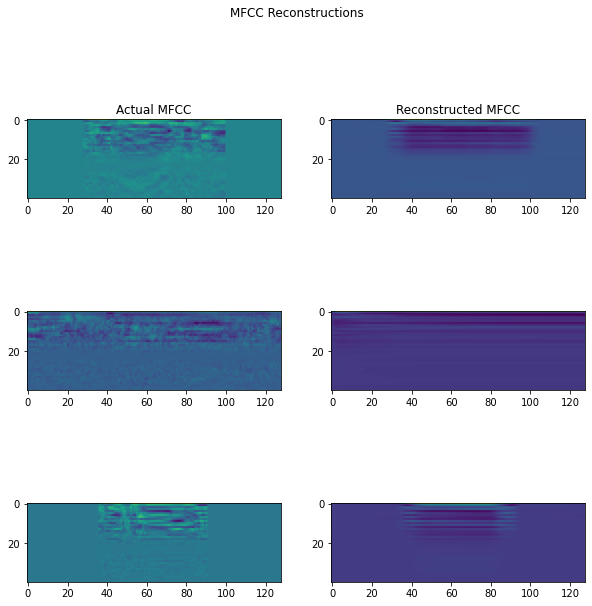

In [16]:
#Load the best model, test and report metrics
path_checkpoint = "lstm_autoencoder_checkpoint.h5"

#Load best model
lstm_autoencoder = keras.models.load_model(path_checkpoint)

#Test model
test_model(lstm_autoencoder, x_test)

In [17]:
#Evaluate Encoder
encoder = keras.Model(lstm_autoencoder.layers[0].input, lstm_autoencoder.layers[2].output)

evaluate_encoder(encoder, x_test, test_labels)

Size of labels 9699
Number of unique words 3002
The number of positive examples 86825 and negative examples 46943626


0.003301478827099132

In [25]:
#Clear Keras
tf.keras.backend.clear_session()

## 4. CNN Model

In [21]:
def create_cnn1d_autoencoder(input_shape):
    #Model Input
    inputs = keras.layers.Input(shape=input_shape)

    #Model Definition

    #Encoder
    x = keras.layers.Conv1D(32, 10, activation='relu', padding="same")(inputs)
    x = keras.layers.MaxPooling1D(4)(x)
    x = keras.layers.Conv1D(64, 10, activation='relu', padding="same")(x)
    x = keras.layers.MaxPooling1D(4)(x)
    x = tf.keras.layers.Flatten()(x)
    encoded = keras.layers.Dense(256, activation = "relu")(x)
    

    #Decoder
    x = keras.layers.Dense(256, activation = "relu")(encoded)
    x = tf.keras.layers.Reshape((8,-1))(x)
    x = keras.layers.Conv1DTranspose(64, 10, activation='relu', padding="same")(x)
    x = keras.layers.UpSampling1D(4)(x)
    x = keras.layers.Conv1DTranspose(32, 10, activation='relu', padding="same")(x)
    x = keras.layers.UpSampling1D(4)(x)
    decoded = keras.layers.Conv1DTranspose(40, 1, activation='relu')(x)

    #Model creation
    cnn1d_autoencoder = keras.Model(inputs, decoded)
    cnn_1d_encoder = keras.Model(inputs, encoded)
    
    return cnn1d_autoencoder,cnn_1d_encoder

In [22]:
#Create the Model
cnn1d_autoencoder, cnn1d_encoder = create_cnn1d_autoencoder(input_shape)

In [23]:
#Compile the model and define the training parameters

#Optimizer
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

#Compile Model
cnn1d_autoencoder.compile(optimizer = optimizer, loss = "mse")

#Number of Epochs and Batch Size
num_epochs = 100
batch_size = 256

#Model Callbacks for Checkpointing and Early Stopping

#Model Checkpoint Path
path_checkpoint = "cnn1d_autoencoder_checkpoint.h5"

#Get the callbacks
es_callback,modelckpt_callback = create_callbacks(path_checkpoint, early_stopping_patience = 10)

#Model Summary
cnn1d_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 40)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 32)           12832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 64)            20544     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1313

In [24]:
 #Train the model
history = cnn1d_autoencoder.fit(
    x = x_train, y = x_train,
    verbose = 2,
    epochs=num_epochs,
    batch_size = batch_size,
    validation_data=(x_val,x_val),
    callbacks=[es_callback, modelckpt_callback]
)

Epoch 1/100
122/122 - 8s - loss: 103.1673 - val_loss: 91.1934

Epoch 00001: val_loss improved from inf to 91.19338, saving model to cnn1d_autoencoder_checkpoint.h5
Epoch 2/100


ResourceExhaustedError:  OOM when allocating tensor with shape[256,32,1,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_2/conv1d_transpose_2/conv1d_transpose/Conv2DBackpropFilter-2-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_25353]

Function call stack:
train_function


In [ ]:
# Plot Learning Curves
plot_learning_curves(history)

Test MSE  91.82266
Plotting Random Reconstructed Traces
test
test2


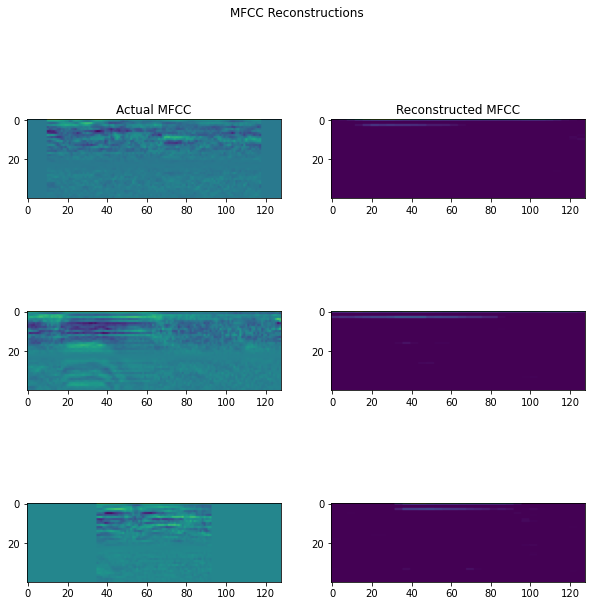

In [18]:
#Load the best model, test and report metrics

#Model Checkpoint Path
path_checkpoint = "cnn1d_autoencoder_checkpoint.h5"

#Load best model
cnn1d_autoencoder = keras.models.load_model(path_checkpoint)


#Test model
test_model(cnn1d_autoencoder, x_test)

## 4. Load Data and Fit Model

## 5. Evaluate Model and Visualize Output